# Update Semantics and Communicative Efficiency

This is the notebook accompanying the thesis, *Update Semantics and Informativeness in Natural Language* by Aram Elias, for the 2021 BSc Artificial Intelligence at the University of Amsterdam.

## Importing Files and Libraries

In [1]:
# Google Colab drive mounting
from google.colab import drive
drive.mount('/content/gdrive')

#file_path = "/content/gdrive/My Drive/Colab Notebooks/"

Mounted at /content/gdrive


In [2]:
import os.path
import pickle
from functools import reduce, lru_cache
from itertools import combinations
from pprint import pprint
from types import FunctionType
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import argparse
from glob import glob
import time
import matplotlib.pyplot as plt
import pandas as pd
import re

from __future__ import division
from fractions import Fraction
import csv

# Boolean Expressivist *Language of Thought*

Based on the paper *Updates and Boolean Universals* by F. Carcassi and G. Sbardolini (2021)

Original code from: https://github.com/thelogicalgrammar/booleanExpressivistLOT


## Tables for Reference

Based on the tables in Carcassi and Sbardolini (2021).

**Truth Tables and Updates**

| Formula | Truth Table | Update &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
| --- | --- | --- |
| `T` | 1111 | $c$ |
| `F` | 0000 | $c[^-c]$ |
| $p$ | 1100 | $c[^+p]$ |
| $q$ | 1010 | $c[^+q]$ |
| `not` $p$ | 0011 | $c[^-p]$ |
| `not` $q$ | 0101 | $c[^-q]$ |
| $p$ `and` $q$ | 1000 | $(c[^+p])[^+q]$ |
| $p$ `or` $q$ | 1110 | $c[^+p, ^+q]$      |
| $p$ `nor` $q$ | 0001 | $(c[^-p])[^-q]$ |
| $p$ `nand` $q$ | 0111 | $c[^-(c[^+p])[^+q]]$ |
| $p$ `XOR` $q$ | 0110 | $(c[^-(c[^+p])[^+q])])[^-(c[^-p])[^-q]]$ |
| $p$ `bc` $q$ | 1001 | $c[^-(c[^-(c[^+p])[^+q])])[^-(c[^-p])[^-q]]]$ |
| $p$ `c` $q$ | 1011 | $c[^-(c[^+p])[^-q]]$ |
| $p$ `ic` $q$ | 1101 | $c[^-(c[^-p])[^+q]]$ |
| $p$ `nc` $q$ | 0100 | $(c[^+p])[^-q]$ |
| $p$ `nic` $q$ | 0010 | $(c[^-p])[^+q]$ |

**Complexity of Connectives**

| Connective | Local | Homogeneous | Positive | Complexity |
| --- | --- | --- | --- | --- |
| `not` ($\neg$) | $\checkmark$ | $\checkmark$ | | 2 | 
| `and` ($\wedge$) | $\checkmark$ | $\checkmark$ | $\checkmark$ | 1 |
| `or` ($\vee$) | $\checkmark$ | $\checkmark$ | $\checkmark$ | 1 |
| `nor` ($\downarrow$) | $\checkmark$ | $\checkmark$ | | 2 |
| `nand` ($\uparrow$) | | | | 4 |
| `XOR` ($\nleftrightarrow$) | | | | 4 |
| `bc` ($\leftrightarrow$) | | | | 4 |
| `c` ($\rightarrow$) | | | | 4 |
| `ic` ($\leftarrow$) | | | | 4 |
| `nc` ($\nrightarrow$) | $\checkmark$ | | | 3 |
| `nic` ($\nleftarrow$) | $\checkmark$ | | | 3 |

## From analysis.py

In [3]:
attested_languages = (
    frozenset(['nor', 'and', 'or', 'not']),
    frozenset(['and', 'or', 'not']),
    frozenset(['and', 'not']),
    frozenset(['or', 'not']),
)

def plot_languages(dict_usage_complexities, dict_cognitive_complexity):
    """
    Plot the languages stored in the dictionaries
    """

    fig, ax = plt.subplots(figsize=(8.27,4))
    for name in dict_usage_complexities.keys():

        # if not any([i in ['nc', 'nic', 'bc', 'XOR', 'c', 'ic'] for i in name]) and 'not' in name:
        if 'not' in name:
        # if True:

            usage_complexity = dict_usage_complexities[name]
            cognitive_complexity = dict_cognitive_complexity[name]

            if name in attested_languages:
                color = 'red'
                zorder = 10
                if name == frozenset(['or', 'not']):
                    yshift = 0.4
                else:
                    yshift = 0
                ax.text(
                    usage_complexity + 0.02,
                    cognitive_complexity + 0.3 + yshift,
                    s=','.join(name),
                    fontsize='x-small'
                )
            else:
                color='black'
                zorder = 1

            ax.scatter(usage_complexity,cognitive_complexity,color=color)

    ax.set_xlabel('Usage complexity')
    ax.set_ylabel('Conceptual complexity')
    ax.set_xlim(1.05,2.8)

    plt.savefig('figure.png', dpi=300, transparent=True)

In [4]:
def get_minimal_languages(folder):
    languages = {}
    for path in glob(folder+'/*.pickle'):
        with open(path, 'rb') as openfile:
            booleans, formulas = pickle.load(openfile)
            # dictionary = {b:f for b,f in zip(booleans,formulas)}
            dictionary = np.column_stack((booleans,formulas))
            name = frozenset(
                os.path.splitext(os.path.basename(path))[0]
                .split('_')
            )
            languages[name] = dictionary
    return languages

## From language_parser.py

### Indentation Levels

In [5]:
# Original function
def get_indentation_levels_old(formula, exclude_brackets):
    if type(formula)==str:
        formula_np = np.array(list(formula)) 
    position_closed = formula_np==')'
    formula_open = formula_np=='('
    formula_close = np.zeros(len(position_closed))
    formula_close[1:] = (np.where(position_closed,-1,0))[:-1]
    formula_level = (formula_close+formula_open).cumsum()
    if exclude_brackets:
        brackets_position = formula_open | position_closed
        formula_without_brackets = formula_np[~brackets_position]
        formula_level_without_brackets = formula_level[~brackets_position]
        return formula_without_brackets, formula_level_without_brackets
    else:
        return formula_np, formula_level

In [6]:
# Optimized (iterates through formula only once)
def get_indentation_levels(formula, exclude_brackets):
    if type(formula) == str:
        formula = np.array(list(formula))
    formula_out = []
    levels = []
    level = 0
    for c in formula:
        if c == '(':
            level += 1
            if not exclude_brackets:
                formula_out.append(c)
                levels.append(level)
        elif c == ')':
            if not exclude_brackets:
                formula_out.append(c)
                levels.append(level)
            level -= 1
        else:
            formula_out.append(c)
            levels.append(level)
    return np.array(formula_out), np.array(levels)

### String Processing

In [7]:
def np_to_string(f):
    return f.astype('|S1').tobytes().decode('utf-8')

In [8]:
def separate(f,levs):
    """
    Parameters
    ----------
    f: array
        np array of characters representing the formula
    levs: array
        Int array of the nesting level of f
        Where argument levels is shifted down so it starts from 0
    Returns
    -------
    list of lists
        Each list contains a tuple (argument f array, argument levels)
    """
    assert len(f)==len(levs), 'formula and scope have different lens'
    # one comma for every argument in main scope.
    # possibly 0, e.g. for negation
    mask_commas_in_main = (f==',')&(levs==0)
    indices_commas_in_main = np.argwhere(mask_commas_in_main).flatten()
    # f without commas in main scope
    f_without_commas = f[~mask_commas_in_main]
    f_separated = np.split(f_without_commas, indices_commas_in_main)
    levs_without_commas = levs[~mask_commas_in_main]
    levs_separated = np.split(levs_without_commas, indices_commas_in_main)
    return zip(f_separated, levs_separated)

### Formula Evaluation

In [9]:
def eval_formula_recursive(f_wo_brackets, level_wo_brackets, m_dict):
    # if it's a basic formula, return its meaning
    if np.all(level_wo_brackets==0):
        return m_dict[np_to_string(f_wo_brackets)]

    # if it's not a basic formula, run this function 
    # on its components and then combine the meanings
    operator = np_to_string(f_wo_brackets[level_wo_brackets==0])
    operator_m = m_dict[operator]

    # split the arguments
    inner_indices = level_wo_brackets > 0
    arguments_tuples = separate(
        f_wo_brackets[inner_indices],
        level_wo_brackets[inner_indices]-1) 

    # run the function on the arguments
    args_meanings = [
        eval_formula_recursive(f,lev,m_dict)
        for f, lev in arguments_tuples]

    return operator_m(*args_meanings)

In [10]:
def evaluate_formula(formula,m_dict):
    """
    The assumption is that the formulas have shape
        OP(formula,formula)
    NOTE: no spaces
    If a formula contains brackets, it should be analysed further
    Otherwise it's a basic expression
    """
    # find the nesting level of every character in the formula
    f_wo_brackets, level_wo_brackets = get_indentation_levels(formula,True)
    return eval_formula_recursive(
        f_wo_brackets,
        level_wo_brackets,
        m_dict
    )

## From utilities.py

In [11]:
def bit_not(n, numbits=4):
    return (1<<numbits)-1-n

In [12]:
def combine(f_1, f_2, first_top_unsaturated):
    """
    Substitute the first argument on top level in f_1 for f_2
    """
    # Old implementation which adds simply
    # to the first occurrence of _
    # return f_1.replace('_',f_2,1)
    return np.concatenate((
        # everything before the _
        f_1[:first_top_unsaturated],
        # the argument itself
        f_2,
        # everything after the _
        f_1[first_top_unsaturated+1:]
    ))

In [13]:
def find_n_args(f):
    """
    Finds the number of arguments of a function
    """
    return f.__code__.co_argcount

### Checking Symmetry

In [14]:
def check_symmetry(new_node, new_nodes, pivot):
    """
    check that new_node is not symmetric to any of new_nodes
    First flips the formula around the pivot, 
    Then checks that the flipped version is not identical to any of
    the nodes in new_nodes
    Parameters
    ----------
    new_node: string
        The node that is proposed to add to the list of new nodes
    new_nodes: list of strings
        The nodes that have already been added in that generation
    levels_top_unsat: boolean array 
        For each char in new_node, whether the char is the same level
    """
    assert new_node[pivot]==',', 'Pivot isnt a comma'
    # the first argument returned is simply new_node
    f, levels = get_indentation_levels(new_node, False)
    # get the last open bracket before the pivot
    # at the same indentation level as the pivot
    before_p = np.nonzero(
        (f[:pivot]=='(') & (levels[:pivot]==levels[pivot])
    )[0][-1]
    # get first closed bracket after the pivot
    # at the same indentation level of the pivot
    after_p = pivot + np.nonzero(
        (f[pivot:]==')') & (levels[pivot:]==levels[pivot])
    )[0][0]

    flipped_node = np.concatenate((
        # include the opening bracket
        f[:before_p+1],
        # from the pivot to before the closing bracket (second arg)
        f[pivot+1:after_p],
        # comma corresponding to the pivot
        np.array([',']),
        # from the after the opening bracket to pivot
        f[before_p+1:pivot],
        # everything after and including the closing bracket
        f[after_p:]
    ))
    return np_to_string(flipped_node) in new_nodes

In [15]:
# isolated version of the flip used in check_symmetry
def flip_formula(formula, pivot):
    assert formula[pivot]==',', 'Pivot isnt a comma'
    f, levels = get_indentation_levels(formula, False)
    # get the last open bracket before the pivot
    # at the same indentation level as the pivot
    before_p = np.nonzero(
        (f[:pivot]=='(') & (levels[:pivot]==levels[pivot])
    )[0][-1]
    # get first closed bracket after the pivot
    # at the same indentation level of the pivot
    after_p = pivot + np.nonzero(
        (f[pivot:]==')') & (levels[pivot:]==levels[pivot])
    )[0][0]

    return np_to_string(np.concatenate((
        f[:before_p+1], f[pivot+1:after_p],
        np.array([',']), f[before_p+1:pivot],
        f[after_p:]
    )))

In [16]:
# switch p and q to see if this formula already exists
def switch_formula(formula):
    formula = list(formula)
    for i in range(len(formula)):
        c = formula[i]
        if c == 'p':
            formula[i] = 'q'
        elif c == 'q':
            formula[i] = 'p'
    return ''.join(formula)

### Find Minimal Formulas

In [17]:
def find_shortest_formulas(m_dict, nesting_limit=7, verbose=True):
    """
    Since formulas are added to saturated in order of complexity,
    whenever I encounter a meaning that's already in 
    saturated, I don't need to add it to saturated
    Because the new meaning is going to be at least
    as complex as the one that's alread in saturated
    Otherwise, add to saturated
    NOTE: this relies on the fact that the shortest
    formula for a meaning is a combination of shortest formulas 
    NOTE: lexicon should contain first p and q, and then
    the other terms in order of complexity
    NOTE: the nesting_limit e.g. =7 means that it will
    only calculate formulas up to 7 and make 'fake'
    formulas of length 8 for everything else
    """

    saturated, saturated_m, unsaturated, unsaturated_m = [], [], [], []

    for k,v in m_dict.items():
        if type(v)==FunctionType:
            n_args = find_n_args(v)
            unsaturated_m.append(v)
            unsaturated.append(k + '(' + ','.join(['_']*n_args) + ')')
        else:
            saturated.append(k)
            saturated_m.append(v)

    # store the formulas and meanings for 
    # each of the unique expressions
    # store unique formulas the you already know the meaning of here
    unique_formulas = [*saturated]
    # store the relative meanings here 
    # NOTE: in the same order
    unique_meanings = [*saturated_m]
    # store the lexicon (which contains the expressions
    # with parentheses like 'not(_)')
    lexicon = [*saturated, *unsaturated]
    lexicon = [np.array(list(a)) for a in lexicon]
    # start with just the initial unsaturated in it
    # unsaturated terminal nodes
    terminal_nodes = [*unsaturated]
    while len(unique_meanings) < 16:
        new_nodes = []
        # loop through the terminal nodes
        for current_node in terminal_nodes:
            # loop through the lexicon
            # and try to add each of the saturated
            for n in lexicon:
                # replace the first occurrence of _ on the top
                # nesting level of current_node with lexicon entry n
                f, levels = get_indentation_levels(
                    current_node, False)
                first_top_unsaturated = np.argmin(
                    np.where(f=='_',levels,np.inf))
                new_node = np_to_string(combine(f, n, first_top_unsaturated))

                # store the levels of the substitution to use it later
                # to find the pivot
                levels_top_unsat = (
                    (levels==levels[first_top_unsaturated])&(f=='_'))

                # when encountering a saturated node, 
                # check if it is in unique already
                # NOTE: not equivalent to nested ifs
                if '_' not in new_node:
                    new_meaning = evaluate_formula(new_node, m_dict)
                    if new_meaning not in unique_meanings:  
                        unique_formulas.append(new_node)
                        unique_meanings.append(new_meaning)
                        if verbose:
                            print((new_node, new_meaning))
                else:
                    # assert levels_top_unsat.sum() < 3, "Strange!"
                    # NOTE: if the character before the '_' is an open
                    # bracket, add directly without checking for symmetry
                    # (python's 'or' short-circuits, so if the first
                    # condition is true the second isn't evaluated)
                    # The condition isn't saved if it's the second arg
                    # AND it's symmetric to a previous expression
                    if (
                            new_node[first_top_unsaturated-1]=='(' or 
                            # TODO: only if the operation is symmetrc
                            not check_symmetry(
                                new_node,
                                new_nodes,
                                first_top_unsaturated-1
                            )):
                        new_nodes.append(new_node)
                # breakpoint()
        # new_nodes, new_m = reduce_symmetric_operators(new_nodes, new_m)
        terminal_nodes = new_nodes
        if verbose:
            print(len(terminal_nodes),'')
            print('len of last: ', terminal_nodes[-1].count('('))
        # print(unique_formulas, '\n')
        # print(terminal_nodes[0])
        # this if means that it has calculated all the formulas up to and including
        # the formulas of length nesting_limit
        if terminal_nodes[-1].count('(') == nesting_limit:
            n_remaining = 16 - len(unique_formulas)
            unique_meanings += [-0000]*n_remaining
            unique_formulas += ['('*(nesting_limit+1)]*n_remaining
            if verbose: print(unique_formulas, '\n')

    return [f'{x:04b}' for x in unique_meanings], unique_formulas

In [18]:
def find_simplest_formulas(m_dict, nesting_limit=7, verbose=True):
    """
    Shorter formulas are not necessarily simpler in terms of cognitive
    complexity. This means we should be able to replace formulas encountered
    earlier with more cognitively simple ones.
    NOTE: this relies on the fact that the shortest
    formula for a meaning is a combination of shortest formulas 
    NOTE: lexicon should contain first p and q, and then
    the other terms in order of complexity
    NOTE: the nesting_limit e.g. =7 means that it will
    only calculate formulas up to 7 and make 'fake'
    formulas of length 8 for everything else
    """
    
    saturated, saturated_m, unsaturated, unsaturated_m = [], [], [], []

    for k,v in m_dict.items():
        if type(v)==FunctionType:
            n_args = find_n_args(v)
            unsaturated_m.append(v)
            unsaturated.append(k + '(' + ','.join(['_']*n_args) + ')')
        else:
            saturated.append(k)
            saturated_m.append(v)

    # store the lexicon (which contains the expressions
    # with parentheses like 'not(_)')
    lexicon = [*saturated, *unsaturated]
    lexicon = [np.array(list(a)) for a in lexicon]
    # start with just the initial unsaturated in it
    # unsaturated terminal nodes
    terminal_nodes = [*unsaturated]

    simplest_dict = dict(zip(saturated_m, saturated))

    while terminal_nodes != [] and terminal_nodes[-1].count('(') != nesting_limit:
        new_nodes = []
        # loop through the terminal nodes
        for current_node in terminal_nodes:
            # loop through the lexicon
            # and try to add each of the saturated
            for n in lexicon:
                # replace the first occurrence of _ on the top
                # nesting level of current_node with lexicon entry n
                f, levels = get_indentation_levels(
                    current_node, False)
                first_top_unsaturated = np.argmin(
                    np.where(f=='_',levels,np.inf))
                new_node = np_to_string(combine(f, n, first_top_unsaturated))

                # store the levels of the substitution to use it later
                # to find the pivot
                levels_top_unsat = (
                    (levels==levels[first_top_unsaturated])&(f=='_'))

                # when encountering a saturated node, 
                # check if A SIMPLER ONE with the same meaning is already there
                # NOTE: not equivalent to nested ifs
                if '_' not in new_node:
                    new_meaning = evaluate_formula(new_node, m_dict)
                    if new_meaning not in simplest_dict.keys():
                        simplest_dict[new_meaning] = new_node
                    else:
                        old_complexity = calculate_formula_complexity(
                            simplest_dict[new_meaning]
                        )
                        new_complexity = calculate_formula_complexity(new_node)
                        if new_complexity < old_complexity:
                            simplest_dict[new_meaning] = new_node

                else:
                    # NOTE: if the character before the '_' is an open
                    # bracket, add directly without checking for symmetry
                    if new_node[first_top_unsaturated-1] == '(':
                        check_flipped = False
                    # check if a flipped or switched version is in new_nodes
                    else:
                        # TODO: only if the operation is symmetric
                        check_flipped = flip_formula(new_node,
                            first_top_unsaturated-1) in new_nodes
                    check_switched = switch_formula(new_node) in new_nodes
                    if not check_flipped and not check_switched:
                        new_nodes.append(new_node)

            terminal_nodes = new_nodes
            if verbose:
                print('nodes: ', len(terminal_nodes))
                print('len of shortest: ',
                      min([n.count('(') for n in terminal_nodes]))
                print('len of last: ', terminal_nodes[-1].count('('))
                print(simplest_dict)

    truth = list(simplest_dict.keys())
    return [f'{x:04b}' for x in truth], [simplest_dict[key] for key in truth]    

### Functionally Complete Languages

In [19]:
f_complete = [
    # one element
    ('nor',),
    ('nand',),
    # two elements
    ('or', 'not'),
    ('and', 'not'),
    ('c', 'not'),
    ('ic', 'not'),
    #('c', 'F'), # optional
    #('ic', 'F'), # optional
    ('c', 'XOR'),
    ('ic', 'XOR'),
    ('c', 'nc'),
    ('c', 'nic'),
    ('ic', 'nc'),
    ('ic', 'nic'),
    ('nc', 'not'),
    ('nic', 'not'),
    #('nc', 'T'), # optional
    #('nic', 'T'), # optional
    ('nc', 'bc'),
    ('nic', 'bc'),
    # three elements
    #('or', 'bc', 'F'), # optional
    ('or', 'bc', 'XOR'),
    #('or', 'XOR', 'T'), # optional
    #('and', 'bc', 'F'), # optional
    ('and', 'bc', 'XOR'),
    #('and', 'XOR', 'T') # optional
]

In [20]:
def calculate_functionally_complete():
    # calculate all combinations of signals
    # of up to 5 elements
    # which are supersets of at least one of the sets in f_complete
    f_all = []
    # list of the binary operators
    names = ['not', 'or', 'and', 'nand', 'nor', 
            'c', 'ic', 'nc', 'nic', 'bc', 'XOR']
    for i in range(1,6):
        for signals_combination in combinations(names, r=i):
            # print([sig in sig_f_complete for sig_f_complete in f_complete])
            if any([
                all([sig in signals_combination for sig in sig_complete_tuple])
                for sig_complete_tuple in f_complete]):
                f_all.append(signals_combination)

    return f_all

In [21]:
def calculate_for_all_functionally_complete(m_dict, verbose=True):
    f_all = calculate_functionally_complete()

    if verbose: pprint(f_all)
    dictionary_complete = {}
    for complete_set in f_all:
        m_dict_restricted = {k:m_dict[k] for k in complete_set}
        m_dict_restricted.update({
            'p': m_dict['p'],
            'q': m_dict['q']
        })
        shortest = find_shortest_formulas(m_dict_restricted, verbose=verbose)
        if verbose:
            print(complete_set)
            print(np.column_stack(shortest),'\n')
        dictionary_complete[complete_set]=np.column_stack(shortest)
    return dictionary_complete

### Expected Complexity

In [22]:
def calculate_expected_complexity(dict_complete):
    """
    Calculates expected complexity for each lang,
    where complexity is calculated as the number of operations 
    in the formula, found as the number of '('.
    Parameters
    ----------
    dict_complete: dict
        Dictionary where each key is a tuple (or ordered dict) of primitives
        and each value is 
    """
    expected_complexity_dict = {}
    for tuple_primitives, shortest_defs in dict_complete.items():
        expected_complexity_dict[tuple_primitives] = np.sum([
            s.count('(') for s in shortest_defs[:,1]
        ])/len(shortest_defs)
    return expected_complexity_dict

In [23]:
# Measure of cognitive complexity, used by multiple functions now
homogeneity_cost = 1
negation_cost = 1
globality_cost = 1
binary_cost = 1
unary_cost = 1

complexities = {
    'not': unary_cost + negation_cost,
    'and': binary_cost,
    'or': binary_cost,
    'nor': binary_cost + negation_cost,
    'nand': binary_cost + globality_cost + negation_cost + homogeneity_cost,
    'XOR': binary_cost + globality_cost + negation_cost + homogeneity_cost,
    'bc': binary_cost + globality_cost + negation_cost + homogeneity_cost,
    'c': binary_cost + globality_cost + negation_cost + homogeneity_cost,
    'ic': binary_cost + globality_cost + negation_cost + homogeneity_cost,
    'nc': binary_cost + negation_cost + homogeneity_cost,
    'nic': binary_cost + negation_cost + homogeneity_cost
}
# complexities = {
#     'not': 1,
#     'and': 1,
#     'or': 1,
#     'nor': 1,
#     'nand': 2,
#     'XOR': 3,
#     'bc': 3,
#     'c': 2,
#     'ic': 2,
#     'nc': 1,
#     'nic': 1
# }

In [24]:
# Applies to a whole language
def calculate_language_complexity(lang_dict):
    """
    # negation_cost = 1
    # complexities = {
    #     'not': 1 + negation_cost,
    #     'and': 1,
    #     'or': 1,
    #     'nor': 1 + 2*negation_cost,
    #     'nand': 2 + 2*negation_cost,
    #     'XOR': 3 + negation_cost,
    #     'bc': 3,
    #     'c': 2 + negation_cost,
    #     'ic': 2 + negation_cost,
    #     'nc': 1 + negation_cost,
    #     'nic': 1 + negation_cost
    # }
    """

    complexity = {
        key: sum([complexities[k] for k in key])
        for key,_ in lang_dict.items()
    }

    return complexity

In [25]:
# Applies to a single formula (NEW!)
def calculate_formula_complexity(formula):
    # a formula with nesting limit should be replaced whenever possible
    if '((' in formula:
        return np.inf
    # else calculate the sum of operator complexities
    split_formula = re.split('\(|\)|,', formula)
    return sum([split_formula.count(key) * complexities[key]
                for key in complexities.keys()])

### Languages File

In [26]:
def save_languages(langs_formatted, path='/content/gdrive/My Drive/Colab Notebooks/functionally_complete'):
    with open(f'{path}.txt', 'w', newline='\n') as openfile:
        openfile.write(langs_formatted)

In [27]:
def update_languages_file(
        file_path='/content/gdrive/My Drive/Colab Notebooks/functionally_complete',
        folder_path='/content/gdrive/My Drive/Colab Notebooks/minimal_formulas',
        verbose=True):
    """
    Parameters
    ----------
    file_path: str
        Path to the file containing the list of functionally complete languages
        which should be updated
    folder_path: str
        Path to the folder containing the pickle files with the minimal formulas
    """
    with open(f'{file_path}.txt', 'r') as openfile:
        currently_stored = [s.strip() for s in openfile]
    remaining_langs = [
        lang for lang in currently_stored
        if not os.path.isfile(f'{folder_path}/{lang}.pickle')
    ]
    if verbose: print(remaining_langs)
    langs_formatted = '\n'.join(remaining_langs)
    save_languages(langs_formatted, file_path)


## Flexible Nesting Limit

In [28]:
def flexible_nesting_limit(language_size):
    if language_size == 1:
        return 14
    elif language_size == 2:
        return 11
    else:
        return 8

## Main Function

Run the cells below to run the simulation.

In [29]:
total_dict = {
    'p': 0b1100,
    'q': 0b1010,
    'F': 0b0000,
    'T': 0b1111,
    'not': lambda x: bit_not(x),
    'or': lambda x, y: x|y,
    'and': lambda x, y: x&y,
    'nand': lambda x, y: bit_not(x&y),
    'nor': lambda x, y: bit_not(x|y),
    'c': lambda x, y: bit_not(x)|y,
    'ic': lambda x, y: bit_not(y)|x,
    'nc': lambda x, y: bit_not(bit_not(x)|y),
    'nic': lambda x, y: bit_not(bit_not(y)|x),
    'bc': lambda x, y: (x&y)|(bit_not(x)&bit_not(y)),
    'XOR': lambda x, y: bit_not((x&y)|(bit_not(x)&bit_not(y)))
}

In [30]:
def update_complexity(action, primitives, verbose=True):

    if action == 'all_minimal':
        languages = get_minimal_languages('/content/gdrive/My Drive/Colab Notebooks/minimal_formulas')
        dict_usage_complexity = calculate_expected_complexity(languages)
        dict_cognitive_complexity = calculate_language_complexity(languages)
        dict_complete = calculate_for_all_functionally_complete(total_dict)
        dict_complexities_3 = calculate_expected_complexity(dict_complete)
        if verbose:
            pprint(list(sorted(dict_complexities_3.items(), key=lambda x:x[1])))
        dict_complexities_1 = calculate_language_complexity(dict_complete)
        return dict_complexities_1

    elif action == 'single_minimal':
        file_path = f'/content/gdrive/My Drive/Colab Notebooks/minimal_formulas/{primitives}.pickle'
        primitives = primitives.split('_')
        m_dict_restricted = {k:total_dict[k] for k in primitives + ['p', 'q']}
        shortest = find_shortest_formulas(m_dict_restricted, verbose=verbose)
        with open(file_path, 'wb') as openfile:
            pickle.dump(shortest, openfile)
        return shortest

    elif action == 'single_shortest':
        file_path = f'/content/gdrive/My Drive/Colab Notebooks/minimal_formulas/{primitives}.pickle'
        primitives = primitives.split('_')
        m_dict_restricted = {k:total_dict[k] for k in primitives + ['p', 'q']}
        if verbose: print('Language: ', primitives, '\nNesting limit: ', limit)
        return find_shortest_formulas(m_dict_restricted, verbose = verbose)
        
    elif action == 'single_simplest':
        file_path = f'/content/gdrive/My Drive/Colab Notebooks/minimal_formulas/{primitives}.pickle'
        primitives = primitives.split('_')
        m_dict_restricted = {k:total_dict[k] for k in primitives + ['p', 'q']}
        limit = flexible_nesting_limit(len(primitives))
        print('Language: ', primitives, '\nNesting limit: ', limit)
        simplest = find_simplest_formulas(m_dict_restricted,
                                      nesting_limit = limit,
                                      verbose = verbose)
        return dict(zip(simplest[0], simplest[1]))

    elif action == 'save_functionally_complete':
        complete_langs = calculate_functionally_complete()
        langs_formatted = '\n'.join([
            '_'.join(a) for a in complete_langs
        ])
        save_languages(langs_formatted)

    elif action == 'update_languages_file':
        update_languages_file(verbose=verbose)

### Evaluation
This function, `update_complexity_timed`, tests how long the algorithm takes to run. These times are then plotted and averaged.

**Arguments:**

* `rounds`: Number of times to run the algorithm, to average over.
* `action`: Type of action to undertake.
  * `'all_minimal'`: Calculate the minimal formulas for all languages.
  * `'single_minimal'`: Calculate the minimal formulas for one (given) language.
  * `'save_functionally_complete'`: Save all functionally complete languages.
  * `'update_languages_file'`: Update the languages file.
* `primitives`: The primitives of a language, if `action` = `'single_minimal'`.
* `verbose`: Whether or not to include print statements during the process.

In [31]:
def update_complexity_timed(rounds, action, primitives, verbose):
    
    if verbose: print('Starting...')
    times = []
    for i in range(rounds):
        start = time.time()
        update_complexity(action, primitives, verbose)
        end = time.time()
        if verbose: print('Round {} / {} complete'.format(i + 1, rounds))
        times.append(end - start)

    plt.plot(times)
    plt.xlabel('Round')
    plt.ylabel('Time (s)')
    plt.show()

    return np.mean(times)


#print('The simulation takes an average of {} seconds.'.format(
#    update_complexity_timed(3, 'single_minimal', 'or_bc_XOR', False)
#    )
#)

# Communicative Efficiency Model

Based on the paper *NAND and the communicative efficiency model* by W. Uegaki (2020)

Original code from: https://github.com/wuegaki/connectives

## From ConnectiveCompInfo.py



In [32]:
# Define the powerset function that generates all the subsets of a set. 
def powerset(seq):
    if len(seq) <= 1:
        yield seq
        yield []
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]]+item
            yield item

# Optimized subset function:
def subset(sub,sup):
	  return all(x in sup for x in sub)

## Scalar Implicature

### Innocently Excludable Alternatives

In [33]:
# A function returning the set of innocently excludable alternatives given a prejacent word and the language (set of words)
def ie_fun(prej,lang):
    # first we take the alts that are non-weaker 
    alts = []
    for alt in lang:
        zipobj = zip(prej,alt)
        print([(i, j) for i, j in zipobj])
        if any(prej_i > alt_i for prej_i, alt_i in zipobj): # If the alt is non-weaker than the prej, 
            print(alt)
            alts = alts + [alt] # add the alt to the set of alts
    if alts == []:
        return []

	  # From the given set of alternatives, we derive all the possible subsets (powerset) minus the empty set. 
    power = list(powerset(alts))
    power.remove([])

    ieset = []
    for altset in power:
        negaltsets = map(lambda x: map(lambda y: int(not(y)),x),altset)  # This inverts the truth values of words in altset
	      # print altset, negaltsets  
        withprej = negaltsets + [prej]   # combines the negated altset with the prejacent
	      # print withprej
        if any(all(w[i] == 1 for w in withprej) for i in range(4)): # if withprej is consistent (i.e., if it contains any 1 across all words)
            if ieset == []:               # in the beginning, just add the altset currently considering to the ieset
                ieset = [altset]
            else:                         # from the second time and on, we have to consider the maximality of the altset
                for s in ieset:
                    if subset(s,altset):   # if a member of ieset is already a subset of altset currently considering
                        i = ieset.index(s)  # retrieve the index of the subset already in ieset
                        del ieset[i]        # remove the subset from ieset
                        ieset = ieset + [altset] # update the ieset with the altset currently considering
                    elif not(any(subset(altset,s) for s in ieset)): # Otherwise, and if there is no member of ieset that is a superset of altset under consideration
                        ieset = ieset + [altset] # update the ieset with the altset currently considering				
    if ieset == []:
        return []

    # get the intersection of ieset
    ie = []
    for alt in ieset[0]:
        if all(alt in ieset[i] for i in range(1,len(ieset))):
            ie = ie + [alt]

    return ie

### Strengthened Meanings and Representations

In [34]:
# Function that returns the strengthened meaning of a prejacent word given the prejacent word and the language
def si(prej,lang):
    ie = ie_fun(prej,lang)
    if ie == []:
		    return prej
    negie = list(map(lambda x: list(map(lambda y: int(not(y)),x)),ie))
    combined = negie + [prej]
    strengthened = [0]*4
    for i in range(4):
        if all(w[i]==1 for w in combined):
            strengthened[i] = 1
		      # else:
		      # 	strengthened[i] = 0
    return strengthened

In [35]:
# Function that returns the strengthened representation of a language by strengthening each word in it
def strengthen(lang):
	  # new_lang = []
	  new_lang = [[]]*len(lang)
	  for i in range(len(lang)):
		    si_word = si(lang[i],lang)
		    new_lang[i] = si_word
	  return new_lang

In [36]:
# Define several utility functions
def utility(world1,world2):
	  if world1 == world2:
		    return 1
	  elif (world1 == 0 and world2 == 3) or (world1 == 3 and world2 == 0):
		    return 1/3
	  else:
		    return 1/2

def utility2(world1,world2):
	  if world1 == world2:
		    return 1
	  else:
		    return 0

def utility3(world1,world2):
	  if world1 == world2:
		    return 1
	  elif (world1 == 0 and world2 == 3) or (world1 == 3 and world2 == 0):
		    return 0
	  else:
		    return 1/2

In [37]:
# Function that returns the informativeness value of a language
def info(lang):
    info = 0
    for world in range(4):
        truewords = list(filter(lambda x: x[world] == 1, lang))
        for word in truewords:
            for world2 in range(4):
                if word[world2] == 1:
                    info = info + 1/len(truewords)*1/sum(word)*utility3(world,world2)
    return info

## From ConnectiveCompInfoPareto.py

In [41]:
# Function that returns the informativeness value of a language
def info_pareto(lang):
	  info = 0
	  for world in range(4):
		    truewords = list(filter(lambda x: x[world] == 1, lang))
		    for word in truewords:
			      for world2 in range(4):
				        if word[world2] == 1:
					          info = info + (Fraction('1/4'))*(Fraction(1/len(truewords)))*(Fraction(1/sum(word)))*utility2(world,world2)

	  return float(info)

In [42]:
#connective_names={
#	  "TAU": [1,1,1,1],
#	  "<-": [1,1,0,1],
#	  "P": [1,1,0,0],
#	  "->": [1,0,1,1],
#	  "Q": [1,0,1,0],
#	  "<->": [1,0,0,1],
#	  "NAND": [0,1,1,1],
#	  "XOR": [0,1,1,0],
#	  "NOTQ": [0,1,0,1],
#	  "ONLYP": [0,1,0,0],
#	  "NOTP": [0,0,1,1],
#	  "ONLYQ": [0,0,1,0],
#	  "NOR": [0,0,0,1],
#	  "CONT": [0,0,0,0],
#	  "OR": [1,1,1,0],
#	  "AND": [1,0,0,0],
#	  "NOR": [0,0,0,1],
#	  "NAND": [0,1,1,1]	
#}

connective_names = {
    'p': '1100',
    'q': '1010',
    'T': '1111',
    'F': '0000',
    'and': '1000',
    'or': '1110',
    'XOR': '0110',
    'c': '1011',
    'ic': '1101',
    'bc': '1001',
    'nc': '0100',
    'nic': '0010',
    'nand': '0111',
    'nor': '0001',
    'not': '0000' # ???
}

In [43]:
def name(word):
	  for x in connective_names:
		    if word==connective_names[x]:
			      wordname=x
	  return wordname

# optimized function	
def names(lang):
	  return [name(word) for word in lang]

In [44]:
# check if x dominates y (MIND THE ORDER)
def pareto_dominant(x, y):
    return all(x >= y) and any(x > y)

In [45]:
# NOT the same as the original!
def identify_pareto(efficient):
    population_size = efficient.shape[0]
    indices = np.arange(population_size)
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        for j in range(population_size):
            # Check if our 'i' point is dominated by our 'j' point
            if pareto_dominant(efficient[j], efficient[i]):
                pareto_front[i] = 0
                break
    # Return indices on Pareto front
    return indices[pareto_front]

# Combining Update Semantics with Communicative Efficiency

In [46]:
# looks up a formula in a dictionary as given by a meaning
# and returns it and its complexity if they exist, otherwise '-' and inf
def check_formula_complexity(formula_dict, key):
    if key in formula_dict.keys():
        formula = formula_dict[key]
        if '((' in formula:
            complexity = np.inf
        else:
            complexity = calculate_formula_complexity(formula)
    else:
        formula = '-'
        complexity = np.inf
    return formula, complexity

In [47]:
def expected_cognitive_complexity(formula_dict):
    """
    Calculates expected complexity for ONE lang,
    where complexity is calculated as the number of operations 
    in the formula, based on COGNITIVE COMPLEXITY.
    Parameters
    ----------
    dict_complete: dict
        Dictionary where each key is a tuple (or ordered dict) of primitives
        and each value is 
    """
    return np.mean([check_formula_complexity(formula_dict, key)[1]
                    for key in connective_str])

## Comparing Complexity Measures

In [48]:
#test_language = 'nand'
test_language = 'and_or_not_c'
#test_language = 'and_or_not_nor_c_nc_ic_bc_nic_XOR_nand'

In [49]:
shortest = update_complexity('single_minimal',
                            test_language,
                            verbose=False)
formula_dict_shortest = dict(zip(shortest[0], shortest[1]))

In [ ]:
formula_dict_simplest = update_complexity('single_simplest',
                                          test_language,
                                          verbose=False)

Language:  ['and', 'or', 'not', 'c'] 
Nesting limit:  8


In [ ]:
connective_values1_str = {
	  '1110': 1,
	  '1000': 1,
	  '1101': 2,
	  '1011': 2, 
	  '0111': 2,
	  '0100': 2,
	  '0010': 2,
	  '0001': 2,
	  '1100': 3,
	  '1010': 3,
	  '0000': 3,
	  '1111': 4,
	  '1001': 4,
	  '0110': 4,
	  '0101': 4,
	  '0011': 4
}

data = []
for key in connective_values1_str.keys():
    f_shortest, c_shortest = check_formula_complexity(formula_dict_shortest, key)
    f_simplest, c_simplest = check_formula_complexity(formula_dict_simplest, key)
    data += [{'truth table':key,
              'shortest formula': f_shortest,
              #'basic complexity': connective_values1_str[key],
              'length 1': f_shortest.count('('),
              'shortest complexity': c_shortest,
              'simplest formula': f_simplest,
              'length 2': f_simplest.count('('),
              'cognitive complexity': c_simplest,
              'difference': c_shortest - c_simplest
              }]

test_data = pd.DataFrame(data)
test_data.to_csv(f'/content/gdrive/My Drive/Colab Notebooks/{test_language}.csv')
test_data

,truth table,shortest formula,basic complexity,length 1,shortest complexity,simplest formula,length 2,cognitive complexity,difference
0,1110,"or(p,q)",1,1,1.0,"or(p,q)",1,1,0.0
1,1000,"and(p,q)",1,1,1.0,"and(p,q)",1,1,0.0
2,1101,"c(q,p)",2,1,4.0,"or(p,not(q))",2,3,1.0
3,1011,"c(p,q)",2,1,4.0,"or(not(p),q)",2,3,1.0
4,0111,"not(and(p,q))",2,2,3.0,"not(and(p,q))",2,3,0.0
5,0100,"and(p,not(q))",2,2,3.0,"and(p,not(q))",2,3,0.0
6,0010,"and(q,not(p))",2,2,3.0,"and(not(p),q)",2,3,0.0
7,0001,"not(or(p,q))",2,2,3.0,"not(or(p,q))",2,3,0.0
8,1100,p,3,0,0.0,p,0,0,0.0
9,1010,q,3,0,0.0,q,0,0,0.0


## Computing Pareto Frontier

In [50]:
connective_str = ['1111', '1110', '1101', '1100', '1011', '1010', '1001', '1000', '0111', '0110', '0101', '0100', '0011', '0010', '0001', '0000']

In [51]:
# turns a truth value string into a list
# i.e. '1010' to [1, 0, 1, 0]
def string_to_bits(c):
    return list([int(i) for i in c])

### Custom Strengthening

In [52]:
# Modified version of ie_fun
def ie_cognitive(prej,lang):

    # first we take the alts that are non-weaker
    alts = []
    for alt in lang:
        # If the alt is non-weaker than the prej
        if any(prej_i > alt_i for prej_i, alt_i in list(zip(prej,alt))):  
            alts = alts + [alt]
    if alts == []:
        return []
 
    power = list(powerset(alts))
    power.remove([])

    ieset = []
    for altset in power:
        # This inverts the truth values of words in altset
        #negaltsets = map(lambda x: map(lambda y: int(not(y)),x),altset)  
        negaltsets = list(map(lambda x: list(map(lambda y: int(not(y)),x)),altset))
        withprej = negaltsets + [prej]   # combines the negated altset with the prejacent
        if any(all(w[i] == 1 for w in withprej) for i in range(4)): # if withprej is consistent (i.e., if it contains any 1 across all words)
            if ieset == []:               # in the beginning, just add the altset currently considering to the ieset
                ieset = [altset]
            else:                         # from the second time and on, we have to consider the maximality of the altset
                for s in ieset:
                    if subset(s,altset):   # if a member of ieset is already a subset of altset currently considering
                        i = ieset.index(s)  # retrieve the index of the subset already in ieset
                        del ieset[i]        # remove the subset from ieset
                        ieset = ieset + [altset] # update the ieset with the altset currently considering
                    elif not(any(subset(altset,s) for s in ieset)): # Otherwise, and if there is no member of ieset that is a superset of altset under consideration
                        ieset = ieset + [altset] # update the ieset with the altset currently considering				
    if ieset == []:
        return []

    # get the intersection of ieset
    ie = []
    for alt in ieset[0]:
        if all(alt in ieset[i] for i in range(1,len(ieset))):
            ie = ie + [alt]

    return ie

In [53]:
# Function that returns the strengthened meaning of a prejacent word
# given the prejacent word and the language
# (modified version of si())
def si_cognitive(prej,lang):
    ie = ie_cognitive(prej,lang)
    if ie == []:
		    return prej
    negie = list(map(lambda x: list(map(lambda y: int(not(y)),x)),ie))
    return [int(all(w[i]==1 for w in negie + [prej])) for i in range(4)]

## Final Simulation

The code below randomly generates languages within a given range of lengths, with the option of limiting the generation to only functionally complete ones. Then, it generates a table of cognitive complexity (Carcassi and Sbardolini, 2021) and informativeness (Uegaki, 2020) and computes the Pareto frontier.

In [54]:
# check if a language is functionally complete
# by seeing if any of the f_complete languages is a subset of lang
def check_f_complete(lang):
    return any(subset(f, lang) for f in f_complete)

In [55]:
# generate a set of languages
def generate_languages(min_length=0, max_length=5, complete_only=False):
    languages = list(powerset(list(total_dict.keys())[2:])) # remove p and q!
    languages.remove([])
    if complete_only:
        languages = [lang for lang in languages if check_f_complete(lang)]
    return [lang for lang in languages
            if len(lang) in range(min_length, max_length + 1)]

In [56]:
# a version of the main function without joining things together with _
def quick_simplest(primitives, verbose):
    m_dict_restricted = {k:total_dict[k] for k in primitives + ['p', 'q']}
    limit = flexible_nesting_limit(len(primitives))
    print('Language: ', primitives, '\nNesting limit: ', limit)
    simplest = find_simplest_formulas(m_dict_restricted,
                                      nesting_limit = limit,
                                      verbose = verbose)
    print('Done. Truth values found:', len(simplest[0]))
    return dict(zip(simplest[0], simplest[1]))

In [57]:
# Modified version of pareto code to incorporate cognitive complexity
# Returns a pandas dataframe to use as you please
def pareto_table(min_length=0, max_length=6, verbose=False,
                     complete_only=False):
    # you can choose to only use functionally complete languages
    langs = generate_languages(min_length, max_length, complete_only)

    # Only the f_complete languages;
    # remove/comment this line to execute properly
    langs = [list(f) for f in f_complete]

    langs = sorted(langs, key=len) # Sort by length (number of primitives)
    #np.random.shuffle(langs)
    print('Languages:', len(langs))
    table = []
    for lang in langs:
        # find simplest formulas
        f_simplest = quick_simplest(lang, verbose)
        # strengthened meanings (truth table values as defined by Uegaki)
        meanings = [string_to_bits(connective_names[word]) for word in lang]
        meanings = [si_cognitive(m, meanings) for m in meanings]
        table += [{'Language': '_'.join(lang),
                      'Complexity': expected_cognitive_complexity(f_simplest),
                      'Informativeness': info(meanings)
                      }]
    
    return pd.DataFrame(table)

In [ ]:
table = pareto_table(0, 5, False, True)

Languages: 18
Language:  ['nor'] 
Nesting limit:  14
Done. Truth values found: 16
Language:  ['nand'] 
Nesting limit:  14
Done. Truth values found: 16
Language:  ['or', 'not'] 
Nesting limit:  11
Done. Truth values found: 16
Language:  ['and', 'not'] 
Nesting limit:  11
Done. Truth values found: 16
Language:  ['c', 'not'] 
Nesting limit:  11
Done. Truth values found: 16
Language:  ['ic', 'not'] 
Nesting limit:  11
Done. Truth values found: 16
Language:  ['c', 'XOR'] 
Nesting limit:  11
Done. Truth values found: 16
Language:  ['ic', 'XOR'] 
Nesting limit:  11
Done. Truth values found: 16
Language:  ['c', 'nc'] 
Nesting limit:  11
Done. Truth values found: 16
Language:  ['c', 'nic'] 
Nesting limit:  11
Done. Truth values found: 16
Language:  ['ic', 'nc'] 
Nesting limit:  11
Done. Truth values found: 16
Language:  ['ic', 'nic'] 
Nesting limit:  11
Done. Truth values found: 14
Language:  ['nc', 'not'] 
Nesting limit:  11
Done. Truth values found: 16
Language:  ['nic', 'not'] 
Nesting limit

In [ ]:
# Save the data to a csv for later
table.to_csv('/content/gdrive/My Drive/Colab Notebooks/table.csv', index=False)
table

,Language,Complexity,Informativeness
0,nor,6.000,1.000000
1,nand,12.000,2.000000
2,or_not,4.125,2.000000
3,and_not,4.125,1.000000
4,c_not,6.250,1.666667
5,ic_not,6.750,1.666667
6,c_XOR,7.500,2.000000
7,ic_XOR,7.500,2.000000
8,c_nc,6.125,2.666667
9,c_nic,6.875,2.000000


### Plotting

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


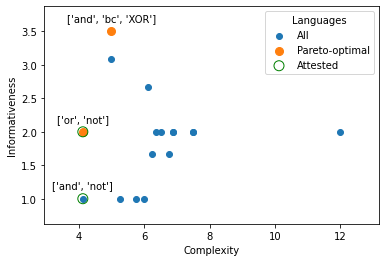

Connectives: ['p', 'q', 'F', 'T', 'not', 'or', 'and', 'nand', 'nor', 'c', 'ic', 'nc', 'nic', 'bc', 'XOR']
Pareto frontier: [['or_not' 4.125 2.0]
 ['and_bc_XOR' 5.0 3.5]]


In [166]:
# Use the data to compute the Pareto frontier
table_np = np.array(pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/table.csv',
                    usecols=['Language', 'Complexity', 'Informativeness']))
# we want to minimize complexity, not maximize it
pareto = identify_pareto(np.array([[-i[1], i[2]] for i in table_np]))
pareto_front = table_np[pareto]

attested = np.array([row for row in table_np
                     if any(all(i in row[0].split('_') for i in a)
                     for a in attested_languages)])

plt.scatter(table_np[:,1], table_np[:,2], label='All')
plt.scatter(pareto_front[:,1], pareto_front[:,2], s=64, label='Pareto-optimal')
plt.scatter(attested[:,1], attested[:,2], facecolors='none', edgecolors='g',
            s=100, label='Attested')
# annotate special languages
langs_to_mark = np.vstack({tuple(lang)
                           for lang in np.concatenate((attested, pareto_front),
                                                      axis=0)})
for lang, x, y in langs_to_mark:
    plt.annotate(lang.split('_'), (float(x), float(y)),
                 textcoords='offset points',
                 xytext=(0, 10), ha='center')
plt.margins(0.15)
plt.xlabel('Complexity')
plt.ylabel('Informativeness')
plt.legend(title='Languages')
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/pareto.png', dpi=200)
plt.show()

print("Connectives:", list(total_dict.keys()))
print("Pareto frontier:", pareto_front)